## Issues to work on: 
- modifying the plotting function, e. g.: 
    - it is restricted to 2 latent variables
    - add/correct axes labels
- extending data simulation: any way to make underlying latent variables for each of the variables in either matrix more complex? E. g. mixtures of latent variables? 

# CCA for different underlying latent structures





In this tutorial, we will simulate data with different underlying structures and see how this affects cca results. This is an important step in understanding the usefulness and meaning of the method. 

You can also quickly check a latent structure you choose yourself using the function that we provide here.

In [180]:
import numpy as np
from scipy.linalg import sqrtm

from statsmodels.multivariate.cancorr import CanCorr as smCCA
from sklearn.cross_decomposition import CCA as skCCA

import matplotlib.pyplot as plt
from seaborn import heatmap

We will first define two functions which make it easy for us to quickly compute and visualize our cca - compute_cca() and plot_cca(). It is not important, to understand them in detail, as this tutorial focuses on data generation, which we will have a closer look at soon. (For the computational details of cca, have a look at the other tutorials, e. g. the introduction, or the tutorial on data reduction.)

## Computing cca
The following function computes a cca using the SVD algebra solution. You need to input your respective matrices - here, we call them X and Y -, and obtain a plot called by plot_cca() to be further explained below.  

In [181]:
def compute_cca(X, Y):

    Cx, Cy = np.corrcoef(X.T), np.corrcoef(Y.T)
    Cxy =  np.corrcoef(X.T, Y.T)[:X.shape[1], X.shape[1]:]
    Cyx =  Cxy.T
    
    sqrt_x, sqrt_y = np.matrix(sqrtm(Cx)), np.matrix(sqrtm(Cy))
    isqrt_x, isqrt_y = sqrt_x.I, sqrt_y.I
    
    W = isqrt_x * Cxy * isqrt_y
    u, s, v = np.linalg.svd(W)
    
    N = np.min([X.shape[1], Y.shape[1]])
    a = np.dot(u, isqrt_x.T[:, :N]) / np.std(X)
    b = np.dot(v, isqrt_y).T / np.std(Y)
    
    X_score, Y_score = X.dot(a), Y.dot(b)

    plot_cca(a, b, X_score, Y_score, s, X, Y)

## Plotting 
This plotting function plots 3 subplots - one that shows the singular values for each canonical vector of the X matrix (y-axis) and component (x-axis), one that shows the singular values for each canonical vector of the Y matrix (y-axis) and component (y-axis), and, finally, one plotting component- and subject-wise the canonical variates of X and Y. It also denotes the correlation between them in the header. 

The third subplot is the most important one, as it visualizes the relationship between the components of X and Y. Here, you have the most direct opportunity to see how different latent structures present in X and Y affect the correlations between them. 

In [182]:
def plot_cca(a, b, U, V, s, X, Y):
    
    N = np.min([X.shape[1], Y.shape[1]])
    plt.figure()
    heatmap(a, square=True, center=0)
    plt.title("Canonical vectors - x")
    plt.figure()
    heatmap(b, square=True, center=0)
    plt.title("Canonical vector - y")

    plt.figure(figsize=(9, 6))
    for i in range(N):

        plt.subplot(221 + i)
        plt.scatter(np.array(X_score[:, i]).reshape(100), 
                    np.array(Y_score[:, i]).reshape(100), 
                    marker="o", c="b", s=25)
        plt.xlabel("Canonical variate of X")
        plt.ylabel("Canonical variate of Y")
        plt.title('Mode %i (corr = %.2f)' %(i + 1, s[i]))
        plt.xticks(())
        plt.yticks(())

## Simulating data flexibly for different latent structures
The function simulate_data() shown below simulates data for different latent structures. You need to input the number of ovservations, variables in X, variables in Y, a one-dimensional array denoting your desired latent structure for X (i.e., you assign a latent variable to each of the variables in X), a one-dimensional array denoting your desired latent structure for Y (i.e., you assign a latent variable to each of the variables in Y), and, finally, the number of latent variables. 

Your array specifying the latent structure for X may look like this: 

In [183]:
lx_array = [0, 1, 1, 1, 0, 0, 0, 0]

This means that you assign variables 1, 5, 6, 7, and 8 in X the same latent variable (denoted by 0). Variables 2, 3, and 4 are governed by a different latent variable (denoted by 1). 

You need to provide a similar array for your variables in Y, for instance: 

In [184]:
ly_array = [1, 1, 1, 1, 1, 1, 1, 1]

Here, the variables in Y are exclusively governed by the second latent variable. As we only distinguish between two different latent variables, the overall number of latent variables is 2. Now consider the following case:  

In [185]:
lx_array = [0, 1, 1, 1, 0, 0, 0, 0]
ly_array = [0, 1, 1, 1, 2, 2, 2, 2]

Here, the overall number of latent variables, which you need to input to the function, is 3, as we assign the variables in X and Y to potentially three different latent variables (denoted by 0, 1, and 2). 

You may choose any number of latent variables for either matrix (in the last example, 2 latent variables underlie the variables in X, and 3 underlie the variables in Y - you can also opt for e. g. only one latent variable governing X, and 2 governing Y). It is important that you assign the latent variables in an ordering way, using integers from 0 to e. g. 3, if the overall number of latent variables is 3. 

In [186]:
def simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent):
    
    """
    Parameters
    ----------
    n_obs : int
        Number of observations (this is common to X and Y)
    x_nvars : int
        Number of (observed) variables in X dataset
    y_nvars : int
        Number of (observed) variables in Y dataset
    lx_array : array 
        Specifying latent factor for each of the variables in X
    ly_array : array 
        Specifying latent factor for of the variables in Y
    n_latent : int
        Number of latent variables hidden in both X and Y datasets
    
    Returns
    -------
    X : array
        Dataset X of size (n_obs, x_nvars) containing n_latent hidden latent variables
    Y : array
        Dataset Y of size (n_obs, y_nvars) containing n_latent hidden latent variables
    """

    l_array = np.ones(shape=(n_obs, n_latent))
    lX = np.ones(shape=(n_obs, x_nvars))
    lY = np.ones(shape=(n_obs, y_nvars))

    for i in range(n_latent):
        l_array[:,i] = np.random.normal(size=n_obs)

    for i in range(x_nvars):
        lx = lx_array[i] 
        lX[:,i] = l_array[:,lx]

    for i in range(y_nvars):
        ly = ly_array[i]
        lY[:,i] = l_array[:,ly]

    X = lX + np.random.normal(size=(n_obs,x_nvars))
    Y = lY + np.random.normal(size=(n_obs,y_nvars))
    
    return X, Y  

## Define different models and compare plots
We will now generate 3 different datasets with different underlying structures, and see how these different structures impact the cca. The number of latent variables will always be 2, and we will vary the arrays specifying in what way the variables in X and Y are governed by these 2 latent variables.

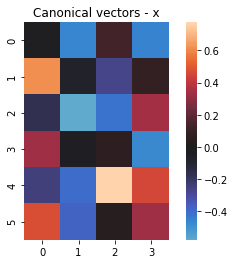

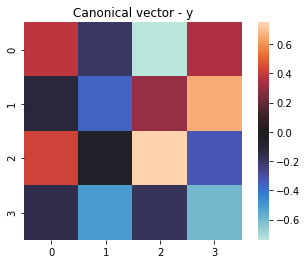

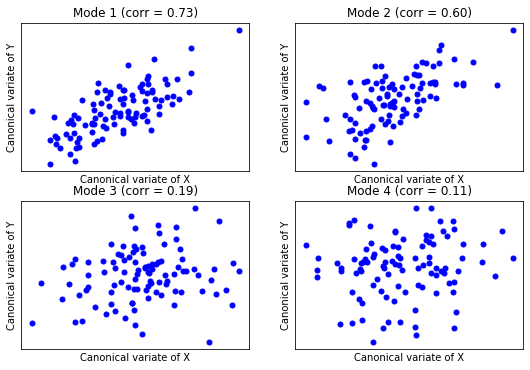

In [200]:
np.random.seed(42)

# model 1
n_obs = 100
n_latent = 2
x_nvars = 6
y_nvars = 4
lx_array = [0, 1, 0, 1, 0, 1]
ly_array = [1, 0, 1, 0]

X0, Y0 = simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent)
compute_cca(X0, Y0)   

As a reminder of what is plotted: the first subplot shows the singular values for each canonical vector of the X0 matrix (y-axis) and component (x-axis), the second shows the singular values for each canonical vector of the Y0 matrix (y-axis) and component (y-axis), and, the third plots component- and subject-wise the canonical variates of X0 and Y0.

The modes refer to plotting different pairs of components: mode 1 refers to the first component of both X0 and Y0, mode 2 to the first and second component of X0, mode 3 to the first and second component of Y0, and mode 4 to the second component of both X0 and Y0.  

It makes sense that the first components of X0 and Y0 correlate most, as the first component of either matrix explains most of its variance. It also makes sense that the correlation is quite high, as the both X0 and Y0 are governed by the 2 latent variables to a similar extent.

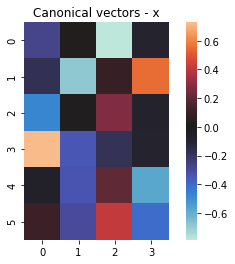

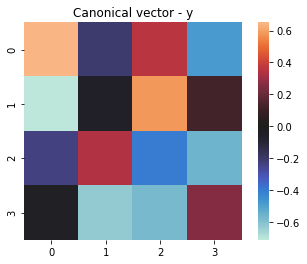

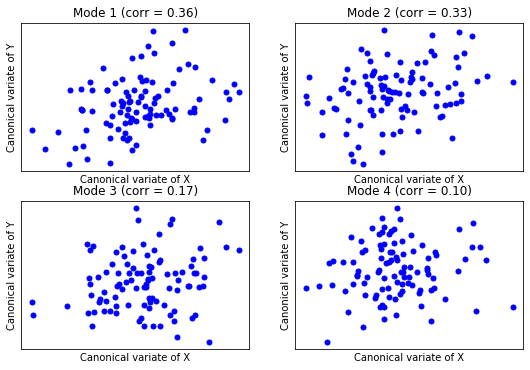

In [201]:
# model 2
np.random.seed(24)

n_obs = 100
n_latent = 2
x_nvars = 6
y_nvars = 4
lx_array = [0, 0, 0, 0, 0, 0]
ly_array = [1, 1, 1, 1] 

X1, Y1 = simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent)
compute_cca(X1, Y1)

In this example, X1 and Y1 are governed entirely by two different latent variables, hence, there is no a priori reason to believe that they should correlate to some substantial extent. This is also reflected in the scatterplots, in which we see a correlation of 0.36 for the first component of both X1 and Y1.

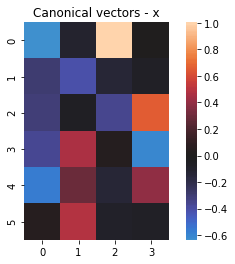

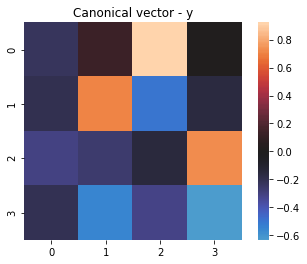

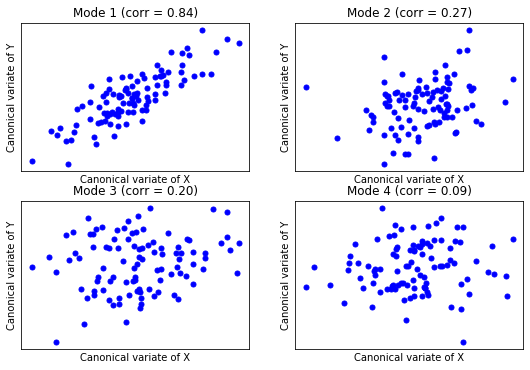

In [202]:
# model 3
n_obs = 100
n_latent = 2
x_nvars = 6
y_nvars = 4
lx_array = [1, 1, 1, 1, 1, 0]
ly_array = [1, 1, 1, 1] 

X2, Y2 = simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent)
compute_cca(X2, Y2)

In this example, X2 and Y2 are governed almost entirely by the same latent variable, hence, we should see a high correlation between the first components of X2 and Y2. (And we do.) 

**Now you can start your own examples!**

In [206]:
# model 4

n_obs = 
n_latent = 
x_nvars = 
y_nvars = 
lx_array = []
ly_array = [] 

X4, Y4 = simulate_data(n_obs, x_nvars, y_nvars, lx_array, ly_array, n_latent)
compute_cca(X4, Y4)